# Vehicle Detection
The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

In [118]:
# Functions From the Udacity program lecture notes:
from functions import *


In [240]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import os
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import svm
import pickle
import time

from moviepy.editor import VideoFileClip

In [63]:
# Training Data

vehicleYES = glob.glob('resource/image/vehicles/**/*.png')
vehicleNO = glob.glob('resource/image/nonVehicles/**/*.png')

nVeh = len(vehicleYES)
nNoVeh = len(vehicleNO)
print("Vehicle images: \t %d \nNon-Vehicle images: \t %d" %(nVeh, nNoVeh))

vehicleImages = []
noVehicleImages = []

# Non-vehicles
for p in vehicleYES:
    img = cv2.imread(p)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    vehicleImages.append(img)
    
for p in vehicleNO:
    img = cv2.imread(p)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    noVehicleImages.append(img)

shape1 = vehicleImages[0].shape
shape2 = noVehicleImages[0].shape



Vehicle images: 	 8792 
Non-Vehicle images: 	 8968


In [65]:
print(shape1, shape2)

(64, 64, 3) (64, 64, 3)


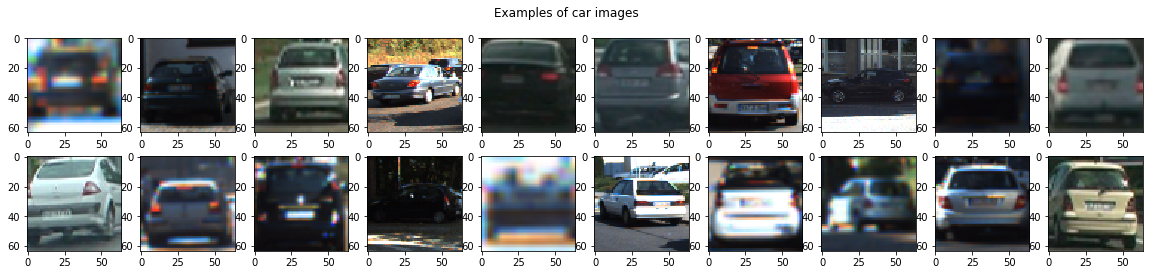

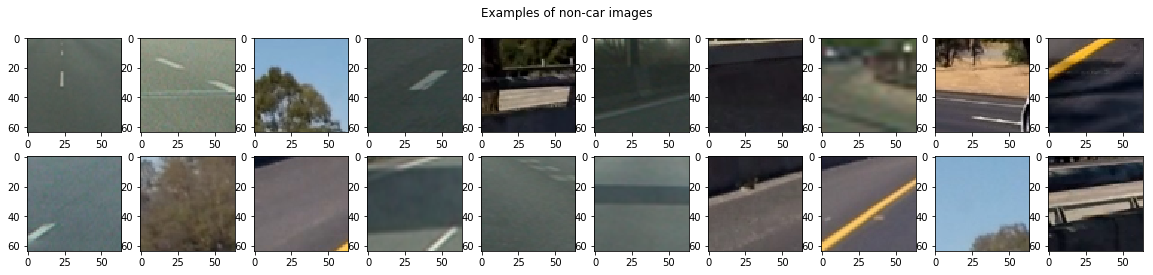

In [66]:
fig1, axs = plt.subplots(2,10, figsize=(20, 4))
# fig1.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()
selectRand1 = np.random.choice(nVeh, 20)
for i,s1 in enumerate(selectRand1):
    img = vehicleImages[s1]
    axs[i].imshow(img)
plt.suptitle("Examples of car images")

fig2, axs = plt.subplots(2,10, figsize=(20, 4))
axs = axs.ravel()
selectRand2 = np.random.choice(nNoVeh,20)
for i,s2 in enumerate(selectRand2):
    img = noVehicleImages[s2]
    axs[i].imshow(img)
plt.suptitle("Examples of non-car images")    


fig1.savefig("example/CarImages.png", bbox_inches='tight')
fig2.savefig("example/noCarImages.png", bbox_inches='tight')

## Histogram of Oriented Gradients (HOG) feature extraction on a labeled training

In [67]:
tCarImg = vehicleImages[1234]
tCarImgg = cv2.cvtColor(tCarImg, cv2.COLOR_RGB2GRAY)
tNoCarImg = noVehicleImages[1234]
tNoCarImgg = cv2.cvtColor(tNoCarImg,cv2.COLOR_RGB2GRAY)

orient = 9
pix_per_cell = 8
cell_per_block = 2

tFeatCar, hogImCar = get_hog_features(tCarImgg, orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)
tFeatNoCar, hogImNoCar = get_hog_features(tNoCarImgg, orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)

In [68]:
print(tFeatCar)
print(tFeatNoCar)

[ 0.55681528  0.21661224  0.25280648 ...,  0.02703493  0.00321664  0.        ]
[ 7.33475787  4.00811479  3.55144552 ...,  0.24131112  0.24131112
  0.02142573]


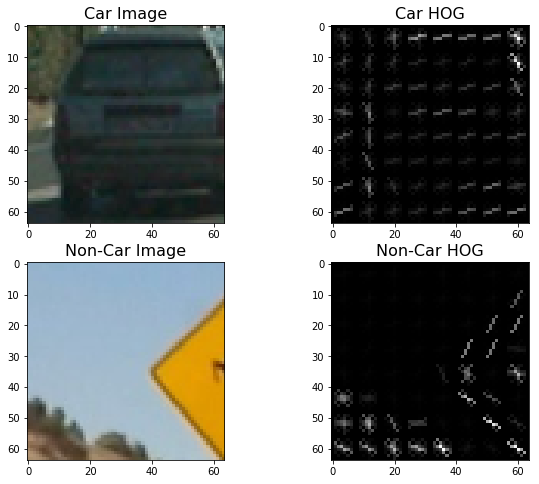

In [71]:

# Visualize 
fig3, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10,8))
#fig3.subplots_adjust(hspace = .4, wspace=.2)
ax1.imshow(tCarImg)
ax1.set_title('Car Image', fontsize=16)
ax2.imshow(hogImCar, cmap='gray')
ax2.set_title('Car HOG', fontsize=16)
ax3.imshow(tNoCarImg)
ax3.set_title('Non-Car Image', fontsize=16)
ax4.imshow(hogImNoCar, cmap='gray')
ax4.set_title('Non-Car HOG', fontsize=16)

fig3.savefig("example/HOGlines.png", bbox_inches='tight')

In [113]:
colorSpace = 'RGB' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb, GRAY
orientation = 30  # HOG orientations
pixPerCell = 16 # HOG pixels per cell
cellPerBlock = 2 # HOG cells per block
hogChannel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatialBinSize = (16, 16) # Spatial binning dimensions
histBins = 16  # Number of histogram bins
spatialFeat = False # Spatial features on or off
histFeat = False # Histogram features on or off
hogFeat = True # HOG features on or off



In [74]:
# Apply Feature Extraction to all images (vehicles and non-vehicles).
"""
Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector.
"""
carFeatures =  extractFeatures(vehicleImages, color_space =colorSpace, spatial_size= spatialBinSize, hist_bins = histBins, 
                               orient=orientation, pix_per_cell=pixPerCell, cell_per_block=cellPerBlock, hog_channel=hogChannel,
                               spatial_feat=spatialFeat, hist_feat=histFeat, hog_feat=hogFeat)
noCarFeatures =  extractFeatures(noVehicleImages, color_space =colorSpace, spatial_size= SpatialBinSize, hist_bins = histBins, 
                               orient=orientation, pix_per_cell=pixPerCell, cell_per_block=cellPerBlock, hog_channel=hogChannel,
                               spatial_feat=spatialFeat, hist_feat=histFeat, hog_feat=hogFeat)



In [137]:
"""
Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
"""
# x vector stacked
X = np.vstack((carFeatures, noCarFeatures)).astype(np.float64)  

# Standardize the image data
scalerf = StandardScaler(copy=True, with_mean=True, with_std=True)
scalerf.fit(X)
Xstd = scalerf.transform(X)


# y vector 
y = np.hstack((np.ones(nVeh), np.zeros(nNoVeh)))

assert len(Xstd)==len(y)

In [87]:
# Randomize train and test sample. use sklearn
# for reproducibility set random splitting seed
seed = 12345

xtrain, xtest, ytrain, ytest = train_test_split(Xstd, y, test_size=0.33, random_state=seed)

t0 = time.time()
clf = svm.SVC()
f1 = clf.fit(xtrain, ytrain)
t1 = time.time()
print('Time elapsed:', round(t1-t0, 2))

# SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
#   decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
#   max_iter=-1, probability=False, random_state=None, shrinking=True,
#   tol=0.001, verbose=False)


Time elapsed: 168.95


In [93]:
# ypred = clf.predict(X=xtest)
# from sklearn.metrics import accuracy_score
# accuracy_score(ypred, ytest)
# # 0.9742364784166524
predAccuracy = clf.score(xtest, ytest)

In [95]:
f1.score(xtest, ytest)

0.9742364784166524

In [90]:
# f1

# from sklearn.metrics import accuracy_score
# acc = accuracy_score(pred, labels_test)
clf.score(xtest, ytest)

0.9742364784166524

In [222]:
# Save model
with open('m1.p', 'wb') as f:
    pickle.dump({'modelFit': f1, "scaler": scalerf}, f)

## Implement a sliding-window technique and use your trained classifier to search for vehicles in images.

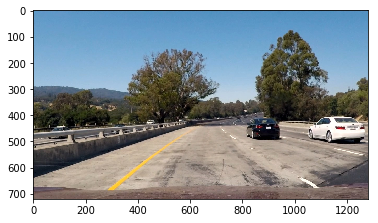

In [99]:
tImage = cv2.imread("resource/test_images/test1.jpg")
tImage = cv2.cvtColor(tImage, cv2.COLOR_BGR2RGB)
plt.imshow(tImage)




In [211]:
h,w = tImage.shape[0:2]

yMinMax = [int(0.5*h), int(0.95*h)] # Min and max in y to search in slide_window()
xMinMax = [int(0.05*w), int(0.95*w)] # slide_window() x axis search area

windowsM = slide_window(tImage, x_start_stop= xMinMax, y_start_stop=yMinMax, xy_window=(120, 120), xy_overlap=(0.7, 0.7))
windowsS = slide_window(tImage, x_start_stop= xMinMax, y_start_stop=yMinMax, xy_window=(60, 60), xy_overlap=(0.6, 0.6))
windowsL = slide_window(tImage, x_start_stop= xMinMax, y_start_stop=yMinMax, xy_window=(200, 200), xy_overlap=(0.8, 0.8))

In [152]:
print(yMinMax, xMinMax)

[360, 684] [64, 1216]


In [212]:


hotWindowsS = search_windows(tImage, windowsS, f1, scaler=scalerf, color_space=colorSpace, spatial_size=spatialBinSize, 
                             hist_bins=histBins, orient=orientation, pix_per_cell=pixPerCell, cell_per_block=cellPerBlock,
                             hog_channel=hogChannel, spatial_feat=spatialFeat, hist_feat=histFeat, hog_feat=hogFeat)
hotWindowsM = search_windows(tImage, windowsM, f1, scaler=scalerf, color_space=colorSpace, spatial_size=spatialBinSize, 
                             hist_bins=histBins, orient=orientation, pix_per_cell=pixPerCell, cell_per_block=cellPerBlock,
                             hog_channel=hogChannel, spatial_feat=spatialFeat, hist_feat=histFeat, hog_feat=hogFeat)
hotWindowsL = search_windows(tImage, windowsL, f1, scaler=scalerf, color_space=colorSpace, spatial_size=spatialBinSize, 
                             hist_bins=histBins, orient=orientation, pix_per_cell=pixPerCell, cell_per_block=cellPerBlock,
                             hog_channel=hogChannel, spatial_feat=spatialFeat, hist_feat=histFeat, hog_feat=hogFeat)




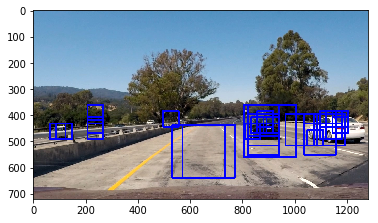

In [213]:
hotWindows= hotWindowsL+hotWindowsM+hotWindowsS

drawImage = np.copy(tImage)
windowImg = draw_boxes(drawImage, hotWindows, color=(0, 0, 255), thick=6)  
plt.imshow(windowImg)


In [214]:
heatmapThresh = 3

2 cars found


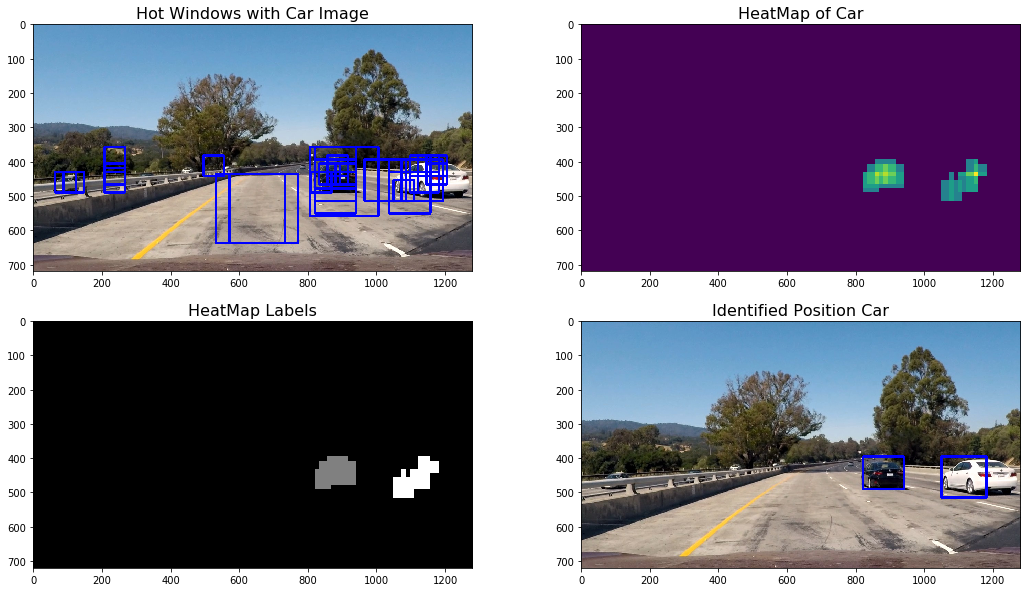

In [216]:
# Calculate and draw heat map

# from functions3 import *
from scipy.ndimage.measurements import label

heatmap = np.zeros((h, w)) 
heatmap = add_heat(heatmap, hotWindows)
heatmap = apply_threshold(heatmap, heatmapThresh)
labels = label(heatmap)
print(labels[1], 'cars found')
# plt.imshow(labels[0], cmap='gray')
# plt.show()

# Draw final bounding boxes
draw_img = draw_labeled_bboxes(np.copy(tImage), labels)


fig5, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(18,10))
#fig3.subplots_adjust(hspace = .4, wspace=.2)
ax1.imshow(windowImg)
ax1.set_title('Hot Windows with Car Image', fontsize=16)
ax2.imshow(heatmap)
ax2.set_title('HeatMap of Car', fontsize=16)
ax3.imshow(labels[0], cmap='gray')
ax3.set_title('HeatMap Labels', fontsize=16)
ax4.imshow(draw_img)
ax4.set_title('Identified Position Car', fontsize=16)

fig5.savefig("example/WindowSearchVehicle.png", bbox_inches='tight')

In [236]:
len(hotWindows)

28

['resource/test_images\\test1.jpg',
 'resource/test_images\\test2.jpg',
 'resource/test_images\\test3.jpg',
 'resource/test_images\\test4.jpg',
 'resource/test_images\\test5.jpg',
 'resource/test_images\\test6.jpg']

In [233]:


def detectCar(img, xScaler, classModel, heatmapThresh = 3):
    """
    Pipeline to detect car, given previously trained model to recognize car
    """
    global colorSpace, spatialBinSize, histBins, orientation, pixPerCell, cellPerBlock, hogChannel
    global spatialFeat, histFeat, hogFeat
            

    h,w = img.shape[0:2]

    yMinMax = [int(0.5*h), int(0.95*h)] # Min and max in y to search in slide_window()
    xMinMax = [int(0.05*w), int(0.95*w)] # slide_window() x axis search area
    
    windowsM = slide_window(img, x_start_stop= xMinMax, y_start_stop=yMinMax, xy_window=(120, 120), xy_overlap=(0.7, 0.7))
    windowsS = slide_window(img, x_start_stop= xMinMax, y_start_stop=yMinMax, xy_window=(60, 60), xy_overlap=(0.6, 0.6))
    windowsL = slide_window(img, x_start_stop= xMinMax, y_start_stop=yMinMax, xy_window=(200, 200), xy_overlap=(0.8, 0.8))

    hotWindowsS = search_windows(img, windowsS, classModel, scaler=xScaler, color_space=colorSpace, spatial_size=spatialBinSize, 
                             hist_bins=histBins, orient=orientation, pix_per_cell=pixPerCell, cell_per_block=cellPerBlock,
                             hog_channel=hogChannel, spatial_feat=spatialFeat, hist_feat=histFeat, hog_feat=hogFeat)
    hotWindowsM = search_windows(img, windowsM, classModel, scaler=xScaler, color_space=colorSpace, spatial_size=spatialBinSize, 
                             hist_bins=histBins, orient=orientation, pix_per_cell=pixPerCell, cell_per_block=cellPerBlock,
                             hog_channel=hogChannel, spatial_feat=spatialFeat, hist_feat=histFeat, hog_feat=hogFeat)
    hotWindowsL = search_windows(img, windowsL, classModel, scaler=xScaler, color_space=colorSpace, spatial_size=spatialBinSize, 
                             hist_bins=histBins, orient=orientation, pix_per_cell=pixPerCell, cell_per_block=cellPerBlock,
                             hog_channel=hogChannel, spatial_feat=spatialFeat, hist_feat=histFeat, hog_feat=hogFeat)

    hotWindows= hotWindowsL+hotWindowsM+hotWindowsS
    
    heatmap = np.zeros((h, w)) 
    heatmap = add_heat(heatmap, hotWindows)
    heatmap = apply_threshold(heatmap, heatmapThresh)
    labels = label(heatmap)
    print(labels[1], 'cars found')
    
    drawImage = np.copy(img)

    windowImg = draw_boxes(drawImage, hotWindows, color=(0, 0, 255), thick=6)  
   # plt.imshow(windowImg)

    # Draw final bounding boxes
    drawFinalBox = draw_labeled_bboxes(drawImage, labels)
    
    return windowImg, heatmap, drawFinalBox
    # heatmapThresh = 33
    # numFrames = 30 # number of video frames over which to accumulate heatmap
    # minBoxRat, maxBoxRat = 0.7, 3.0 # bounding box acceptable aspect ratio range
    # small_bbox_area, close_y_thresh = 80*80, 500
    # min_bbox_area = 40*40
    # use_pretrained = True # load pre-trained SVM model from disk?

#     # Add new hot windows to HotWindows queue
#     hot_windows.add_windows(new_hot_windows)
#     all_hot_windows = hot_windows.get_windows()

#     # Calculate and draw heat map
#     heatmap = np.zeros((720, 1280))  # NOTE: Image dimensions hard-coded
#     heatmap = add_heat(heatmap, all_hot_windows)
#     heatmap = apply_threshold(heatmap, heatmap_thresh)
#     labels = label(heatmap)


2 cars found
0 cars found
1 cars found
7 cars found
5 cars found
3 cars found


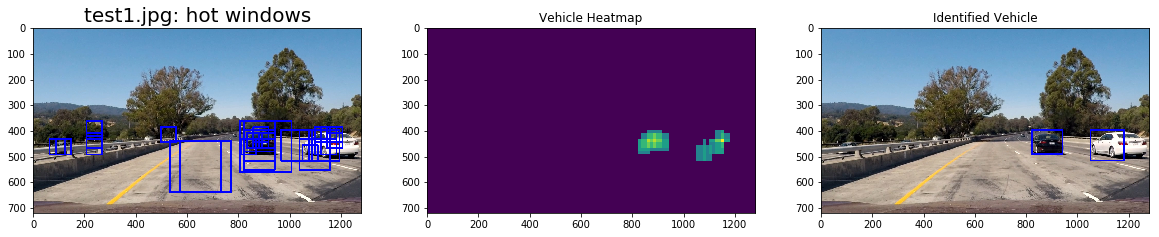

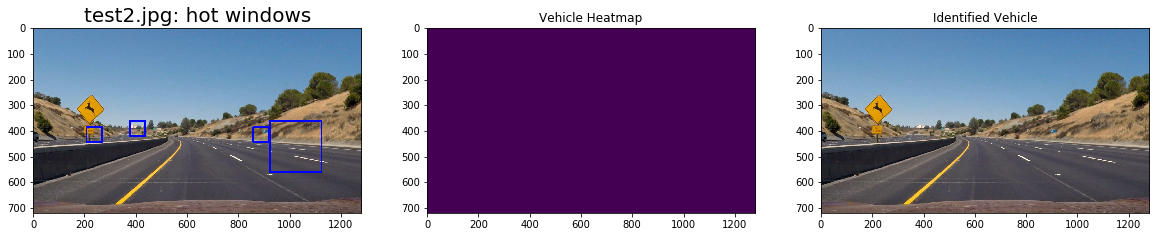

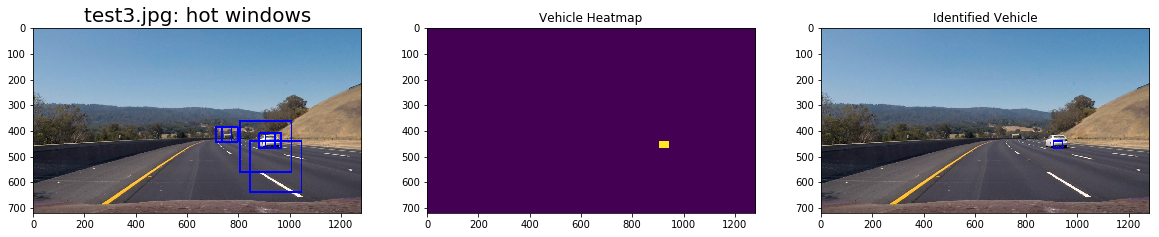

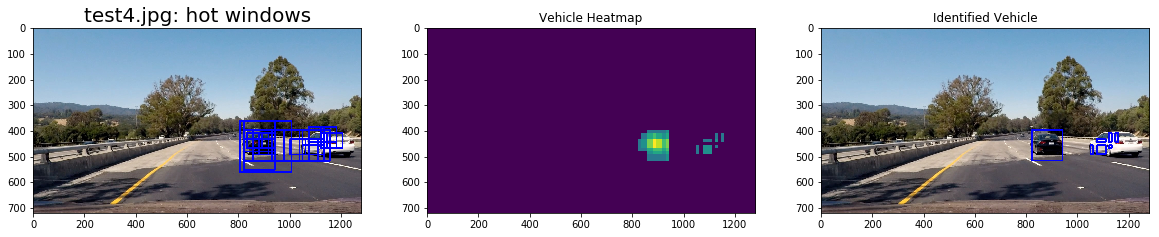

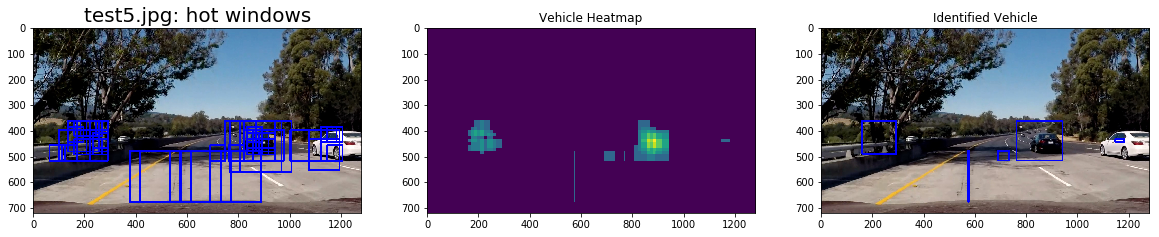

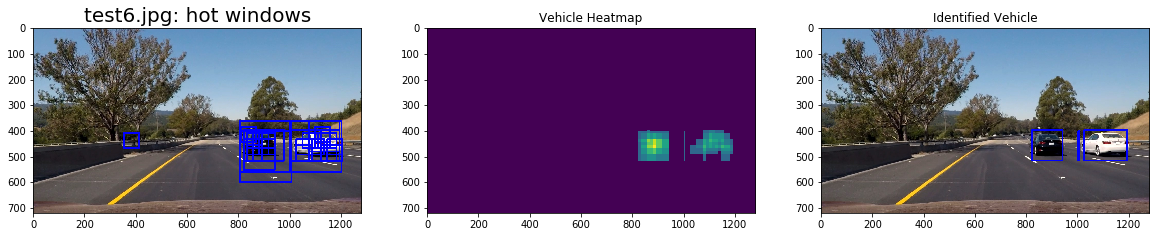

In [234]:
imagesPath = glob.glob("resource/test_images/*jpg")
outPath = "output_images"  
nim = len(imagesPath)
#fig6 = plt.figure(figsize=(20, int((nim+2)/3)*4))
for i, p in enumerate(imagesPath):
    f = plt.figure(figsize=(20, 4))
    img = cv2.imread(p)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    imName = os.path.basename(p)
    windowImg, heatmap, drawFinalBox = detectCar(img, xScaler=scalerf, classModel=f1, heatmapThresh = 3)
    plt.subplot(1,3,1)
    plt.imshow(windowImg)
    plt.title(imName + ": hot windows", fontsize=20)
    plt.subplot(1,3,2)
    plt.imshow(heatmap)
    plt.title("Vehicle Heatmap", fontsize=20)
    plt.subplot(1,3,3)
    plt.imshow(drawFinalBox)
    plt.title("Identified Vehicle", fontsize=20)
    f.savefig(os.path.join(outPath, imName), bbox_inches='tight')
    

In [ ]:
# ws = 100  # windows size
# pover = 0.6 # sliding window overlap percentage
# heatmapThresh = 33
# numFrames = 30 # number of video frames over which to accumulate heatmap
# minBoxRat, maxBoxRat = 0.7, 3.0 # bounding box acceptable aspect ratio range
# small_bbox_area, close_y_thresh = 80*80, 500
# min_bbox_area = 40*40
# use_pretrained = True # load pre-trained SVM model from disk?

In [237]:
class cHotWindows():
    """
    Class that keeps in memory previously found hot windows and and count number of cumulative hot window over time. If subsequent 
    frames also contain hot windows than detect vehicle
    
    self.windows is a queue of lists of bounding boxes,
    where the list can be of arbitrary size.
    Each element in the queue represents the list of
    bounding boxes at a particular time frame.
    """
    def __init__(self, n):
        self.n = n
        # initialize emply list
        self.windows = [] 

    def setWindows(self, newWindows):
        """
        Push new windows to queue 
        remove 1st element from que if fullPop from queue if full
        """
        self.windows.append(newWindows)

        full = len(self.windows) >= self.n
        if full:
            # remove first window from the list
            p = self.windows.pop(0)

    def getWindows(self):
        """
        Concatenate all lists of windows and return as one list
        """
        outWindows = []
        for window in self.windows:
            outWindows = outWindows + window
        return outWindows


In [239]:
def detectCarImSequence(img, xScaler, classModel, heatmapThresh = 3):
    """ 
    Given input_file video, save annotated video to output_file 
    """
    # global instance of class storing previously detected hot windows
    global cHotWindowsInst
    
    global colorSpace, spatialBinSize, histBins, orientation, pixPerCell, cellPerBlock, hogChannel
    global spatialFeat, histFeat, hogFeat
    
    
    h,w = img.shape[0:2]

    yMinMax = [int(0.5*h), int(0.95*h)] # Min and max in y to search in slide_window()
    xMinMax = [int(0.05*w), int(0.95*w)] # slide_window() x axis search area

    windowsM = slide_window(img, x_start_stop= xMinMax, y_start_stop=yMinMax, xy_window=(120, 120), xy_overlap=(0.7, 0.7))
    windowsS = slide_window(img, x_start_stop= xMinMax, y_start_stop=yMinMax, xy_window=(60, 60), xy_overlap=(0.6, 0.6))
    windowsL = slide_window(img, x_start_stop= xMinMax, y_start_stop=yMinMax, xy_window=(200, 200), xy_overlap=(0.8, 0.8))

    hotWindowsS = search_windows(img, windowsS, classModel, scaler=xScaler, color_space=colorSpace, spatial_size=spatialBinSize, 
                             hist_bins=histBins, orient=orientation, pix_per_cell=pixPerCell, cell_per_block=cellPerBlock,
                             hog_channel=hogChannel, spatial_feat=spatialFeat, hist_feat=histFeat, hog_feat=hogFeat)
    hotWindowsM = search_windows(img, windowsM, classModel, scaler=xScaler, color_space=colorSpace, spatial_size=spatialBinSize, 
                             hist_bins=histBins, orient=orientation, pix_per_cell=pixPerCell, cell_per_block=cellPerBlock,
                             hog_channel=hogChannel, spatial_feat=spatialFeat, hist_feat=histFeat, hog_feat=hogFeat)
    hotWindowsL = search_windows(img, windowsL, classModel, scaler=xScaler, color_space=colorSpace, spatial_size=spatialBinSize, 
                             hist_bins=histBins, orient=orientation, pix_per_cell=pixPerCell, cell_per_block=cellPerBlock,
                             hog_channel=hogChannel, spatial_feat=spatialFeat, hist_feat=histFeat, hog_feat=hogFeat)

    hotWindows= hotWindowsL+hotWindowsM+hotWindowsS
        
    # Class containing windows
    cHotWindowsInst.setWindows(hotWindows)
    
    # get all windows
    cumWindows = cHotWindowsInst.getWindows()
    
    ## Note: for the first image cumWindows is equivalent to hotWindows
        

    heatmap = np.zeros((h, w)) 
    heatmap = add_heat(heatmap, cumWindows)
    heatmap = apply_threshold(heatmap, heatmapThresh)
    labels = label(heatmap)

    drawImage = np.copy(img)

   # windowImg = draw_boxes(drawImage, hotWindows, color=(0, 0, 255), thick=6)  
   
    # Draw final bounding boxes
    drawFinalBox = draw_labeled_bboxes(drawImage, labels)

    return drawFinalBox
    
    
def detectFun(img):
    return detectCarImSequence(img, xScaler=scalerf, classModel=f1, heatmapThresh = 3)  


In [244]:
cHotWindowsInst = cHotWindows(n=10)
video0 = VideoFileClip("resource/test_video.mp4")
detVideo0 = video0.fl_image(detectFun)
detVideo0.write_videofile("example/test_video_carDetection.mp4", audio=False)

OSError: [WinError 6] The handle is invalid

In [ ]:
video = VideoFileClip(input_file)
annotated_video = video.fl_image(annotate_image)
annotated_video.write_videofile(output_file, audio=False)


In [ ]:
for image_file in os.listdir(imdir):
		image = mpimg.imread(os.path.join(imdir, image_file))
		draw_image = np.copy(image)

		windows = slide_window(image, x_start_stop=(0, 1280), y_start_stop=(500, 700),
						xy_window=(128, 128), xy_overlap=(pct_overlap, pct_overlap))
		windows = slide_window(image, x_start_stop=(100, 1180), y_start_stop=(400, 500),
						xy_window=(96, 96), xy_overlap=(pct_overlap, pct_overlap))

		hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space,
								spatial_size=spatial_size, hist_bins=hist_bins,
								orient=orient, pix_per_cell=pix_per_cell,
								cell_per_block=cell_per_block,
								hog_channel=hog_channel, spatial_feat=spatial_feat,
								hist_feat=hist_feat, hog_feat=hog_feat)

		window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)

		plt.imshow(window_img)
		plt.show()

		# Calculate and draw heat map
		heatmap = np.zeros((720, 1280))  # NOTE: Image dimensions hard-coded
		heatmap = add_heat(heatmap, hot_windows)
		heatmap = apply_threshold(heatmap, heatmap_thresh)
		labels = label(heatmap)
		print(labels[1], 'cars found')
		plt.imshow(labels[0], cmap='gray')
		plt.show()

		# Draw final bounding boxes
		draw_img = draw_labeled_bboxes(np.copy(image), labels)
		plt.imshow(draw_img)
		plt.show()


## Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles